In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")




In [2]:
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


##Business understanding:
Enhancing clinical decision-making by providing accurate, interpretable, and efficient heart failure risk predictions to support physicians in patient care.


#Data understanding:
Thirteen (13) clinical features:

- age: age of the patient (years)
- anaemia: decrease of red blood cells or hemoglobin (boolean)
- creatinine phosphokinase  (CPK): level of the CPK enzyme in the blood (mcg/L)
- diabetes: if the patient has diabetes (boolean)
- ejection fraction: percentage of blood leaving the heart at each contraction  (percentage)
- high blood pressure: if the patient has hypertension (boolean)
- platelets: platelets in the blood (kiloplatelets/mL)
- sex: woman or man (binary)
- serum creatinine: level of serum creatinine in the blood (mg/dL)
- serum sodium: level of serum sodium in the blood (mEq/L)
- smoking: if the patient smokes or not (boolean)
- time: follow-up period (days)
- [target] death event: if the patient died during the follow-up period (boolean)




#Explatory data analysis:



Missing Values Per Column:

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


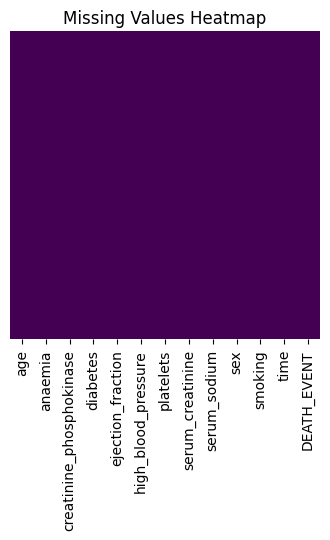

In [3]:


# Handling Missing Values

print("\nMissing Values Per Column:\n")
print(df.isnull().sum())

# Visualizing missing values using a heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()


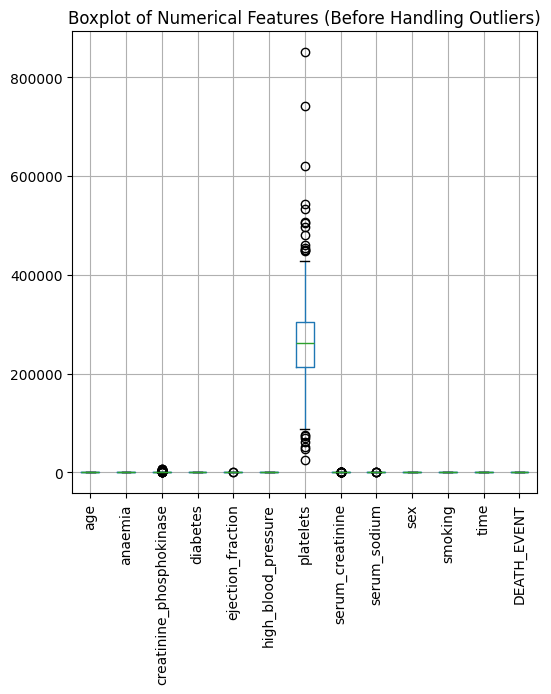

In [4]:
plt.figure(figsize=(6, 6))
df.boxplot(rot=90)
plt.title("Boxplot of Numerical Features (Before Handling Outliers)")
plt.show()


This boxplot visualization helps detect outliers in numerical features.
We applied the IQR (Interquartile Range) method:

In [5]:
import pandas as pd
import numpy as np

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Assuming 'df' is your DataFrame
def analyze_outliers(df):
    outliers = {col: detect_outliers_iqr(df, col) for col in df.select_dtypes(include=[np.number]).columns}

    for col, outlier_rows in outliers.items():
        print(f"Outliers detected in {col}: {len(outlier_rows)}")

    return outliers

outliers = analyze_outliers(df)

Outliers detected in age: 0
Outliers detected in anaemia: 0
Outliers detected in creatinine_phosphokinase: 29
Outliers detected in diabetes: 0
Outliers detected in ejection_fraction: 2
Outliers detected in high_blood_pressure: 0
Outliers detected in platelets: 21
Outliers detected in serum_creatinine: 29
Outliers detected in serum_sodium: 4
Outliers detected in sex: 0
Outliers detected in smoking: 0
Outliers detected in time: 0
Outliers detected in DEATH_EVENT: 0


Findings:


*  Outliers were detected in creatinine_phosphokinase, ejection_fraction, platelets, serum_creatinine, and serum_sodium.
* Outliers can negatively impact model performance by skewing the distribution and affecting learning patterns.


##How did we manage outliers?
We applied capping (Winsorization) to limit extreme values instead of removing them, ensuring that clinically significant cases remain in the dataset



In [6]:
for col in df.select_dtypes(include=[np.number]).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])


###Justification:

* We do not remove outliers because they could represent critical medical conditions.

* Capping ensures that extreme values are within a reasonable range while preserving data integrity.


#PCA for Dimensionality Reduction in Heart Failure Prediction
* **Visualizing Without PCA
Plotting original features to observe raw data distribution and class separation before applying PCA.**



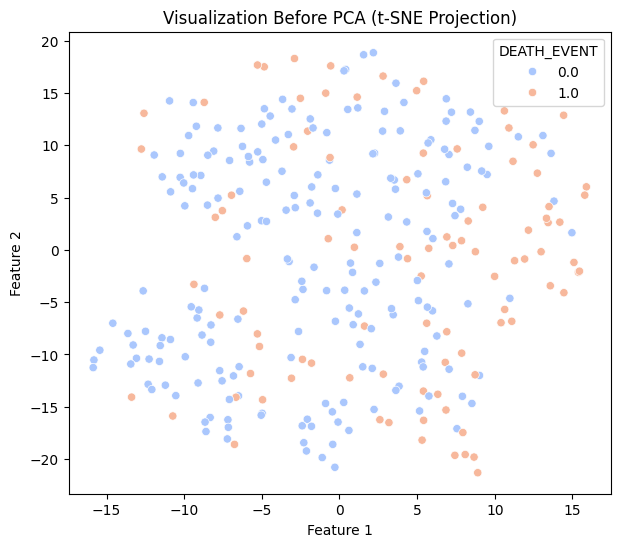

In [7]:

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=['DEATH_EVENT']))
y = df['DEATH_EVENT']

# Apply t-SNE for visualization in 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Convert to DataFrame
tsne_df = pd.DataFrame(X_tsne, columns=['Feature 1', 'Feature 2'])
tsne_df['DEATH_EVENT'] = y.values

# Scatter plot before PCA transformation
plt.figure(figsize=(7,6))
sns.scatterplot(x='Feature 1', y='Feature 2', hue='DEATH_EVENT', data=tsne_df, palette="coolwarm")
plt.title("Visualization Before PCA (t-SNE Projection)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


Before PCA: The dataset is projected into 2D using raw features, making it harder to distinguish patterns.



* **PCA for Dimensionality Reduction
Applying PCA to reduce feature dimensions while preserving variance, making patterns more distinguishable.**

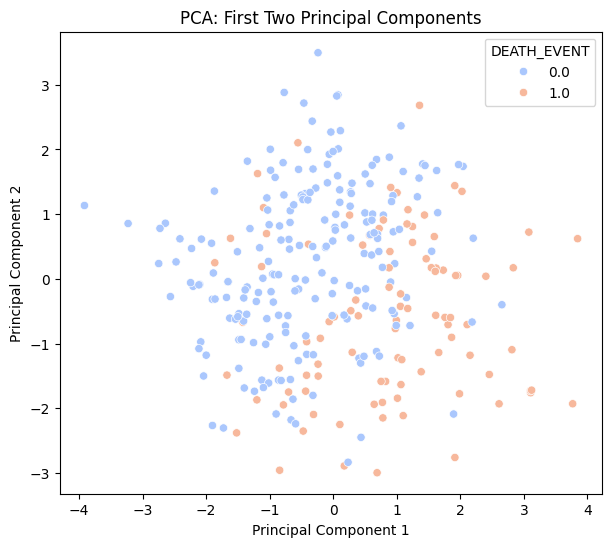

In [16]:
# Apply PCA to retain 95% of the variance
pca = PCA(n_components=0.95)
X_pca_reduced = pca.fit_transform(X_scaled)

# Convert to DataFrame for visualization
pca_df = pd.DataFrame(X_pca_reduced, columns=[f"PC{i+1}" for i in range(X_pca_reduced.shape[1])])
pca_df['DEATH_EVENT'] = y.values

# Scatter plot after PCA transformation
plt.figure(figsize=(7,6))
sns.scatterplot(x="PC1", y="PC2", hue="DEATH_EVENT", data=pca_df, palette="coolwarm")
plt.title("PCA: First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()



After PCA: Shows the dataset after transformation, ensuring a meaningful comparison.



Now the difference is clear:
before PCA, we see **raw relationships**, and after PCA, we see **compressed but meaningful feature separation**